# Import the libraries

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
#import mplcursors
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor


plt.style.use('seaborn-darkgrid')

In [2]:
UneploymentDF = pd.read_csv('COVIDUnemployment.csv')
UneploymentDF

,State,cases,deaths,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018
0,Alabama,387786,14345,2216627,2130845,85782,3.9,49881
1,Alaska,18316,367,352662,329901,22761,6.5,74912
2,Arizona,426614,18857,3422583,3260518,162065,4.7,59079
3,Arkansas,161569,3301,1353305,1303995,49310,3.6,47094
4,California,2664110,102387,19280821,18460725,820096,4.3,75250
5,Colorado,766512,37828,3080661,2983498,97163,3.2,71949
6,Connecticut,1314995,104185,1900664,1821891,78773,4.1,76366
7,Delaware,234327,7813,481773,463542,18231,3.8,65467
8,District of Columbia,229466,10822,404739,381703,23036,5.7,82533
9,Florida,1726811,63147,10173537,9808656,364881,3.6,55433


In [7]:
UneploymentDF.shape

(51, 8)

In [8]:
UneploymentDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   State                         51 non-null     object 
 1   cases                         51 non-null     int64  
 2   deaths                        51 non-null     int64  
 3   Civilian_labor_force_2018     51 non-null     int64  
 4   Employed_2018                 51 non-null     int64  
 5   Unemployed_2018               51 non-null     int64  
 6   Unemployment_rate_2018        51 non-null     float64
 7   Median_Household_Income_2018  51 non-null     int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 3.3+ KB


In [9]:
UneploymentDF.isnull().sum()

State                           0
cases                           0
deaths                          0
Civilian_labor_force_2018       0
Employed_2018                   0
Unemployed_2018                 0
Unemployment_rate_2018          0
Median_Household_Income_2018    0
dtype: int64

In [10]:
UneploymentDF.describe()


,cases,deaths,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018
count,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,51.000000,51.000000,51.000000
mean,1.056306e+06,5.861198e+04,3.164487e+06,3.041220e+06,123266.784314,3.794118,62036.529412
std,2.249183e+06,1.579360e+05,3.569005e+06,3.422712e+06,147350.196414,0.830521,10516.402800
min,1.831600e+04,2.810000e+02,2.914280e+05,2.800760e+05,8804.000000,2.500000,44038.000000
25%,1.696980e+05,4.021000e+03,8.212015e+05,7.883060e+05,27425.500000,3.200000,55340.500000
50%,3.877860e+05,1.425100e+04,2.097202e+06,2.001995e+06,84967.000000,3.800000,60071.000000
75%,1.047118e+06,5.046050e+04,3.796251e+06,3.647934e+06,146783.500000,4.250000,70838.000000
max,1.504181e+07,1.081194e+06,1.928082e+07,1.846072e+07,820096.000000,6.500000,83076.000000


In [11]:
corr = UneploymentDF.corr()
corr

,cases,deaths,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018
cases,1.000000,0.990033,0.478687,0.478129,0.488209,0.112768,0.226888
deaths,0.990033,1.000000,0.385467,0.384831,0.397479,0.109790,0.199162
Civilian_labor_force_2018,0.478687,0.385467,1.000000,0.999987,0.993118,0.105594,0.135606
Employed_2018,0.478129,0.384831,0.999987,1.000000,0.992515,0.102431,0.135910
Unemployed_2018,0.488209,0.397479,0.993118,0.992515,1.000000,0.178296,0.127574
Unemployment_rate_2018,0.112768,0.109790,0.105594,0.102431,0.178296,1.000000,-0.057753
Median_Household_Income_2018,0.226888,0.199162,0.135606,0.135910,0.127574,-0.057753,1.000000


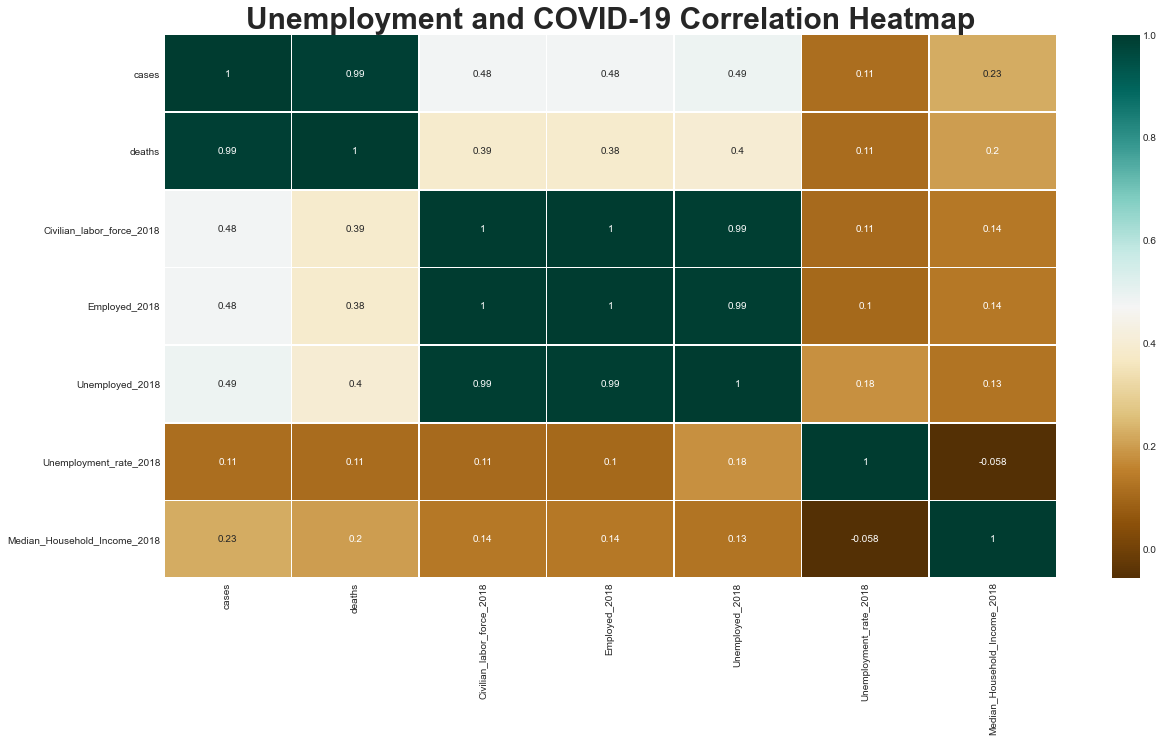

In [12]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap = 'BrBG', annot = True, linewidths = 0.5)
plt.title('Unemployment and COVID-19 Correlation Heatmap', fontweight = 'bold', fontsize = 30);

# Histogram

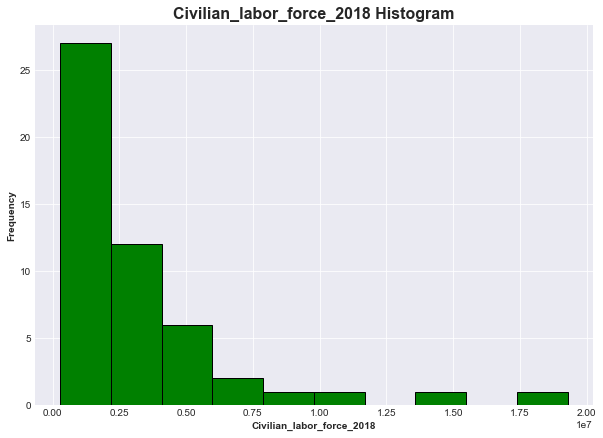

In [13]:
plt.style.use('seaborn-darkgrid')

UneploymentDF['Civilian_labor_force_2018'].plot(kind = 'hist', color = 'green', edgecolor = 'black', figsize = (10,7))
plt.title('Civilian_labor_force_2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Civilian_labor_force_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

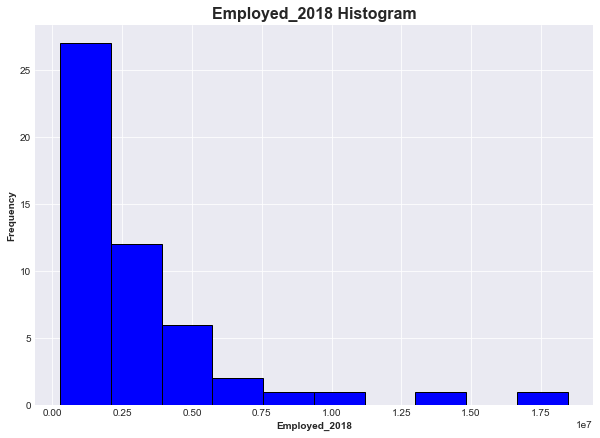

In [14]:
plt.style.use('seaborn-darkgrid')

UneploymentDF['Employed_2018'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Employed_2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Employed_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

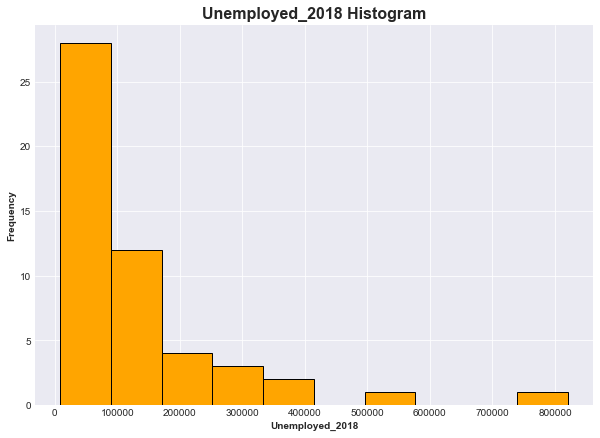

In [15]:
plt.style.use('seaborn-darkgrid')

UneploymentDF['Unemployed_2018'].plot(kind = 'hist', color = 'orange', edgecolor = 'black', figsize = (10,7))
plt.title('Unemployed_2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Unemployed_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

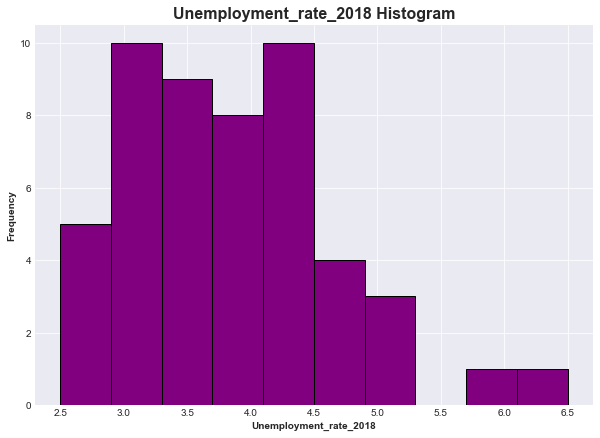

In [16]:
plt.style.use('seaborn-darkgrid')

UneploymentDF['Unemployment_rate_2018'].plot(kind = 'hist', color = 'purple', edgecolor = 'black', figsize = (10,7))
plt.title('Unemployment_rate_2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Unemployment_rate_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

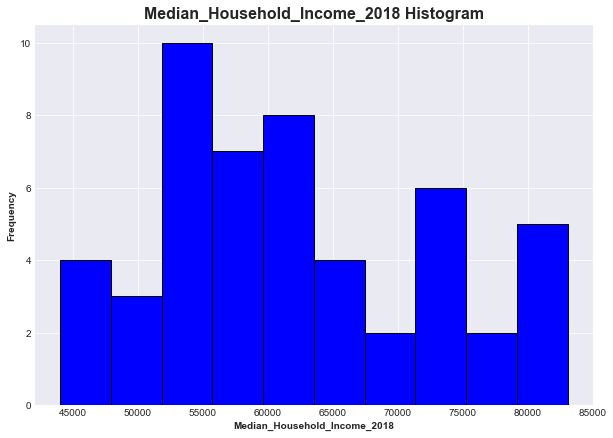

In [17]:
plt.style.use('seaborn-darkgrid')

UneploymentDF['Median_Household_Income_2018'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Median_Household_Income_2018 Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('Median_Household_Income_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

# Violin Plot

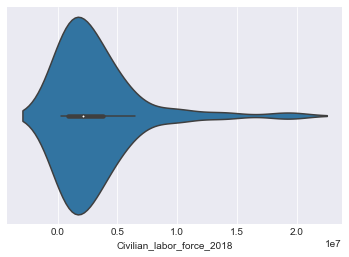

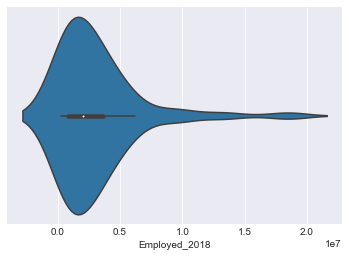

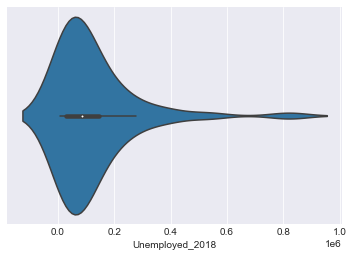

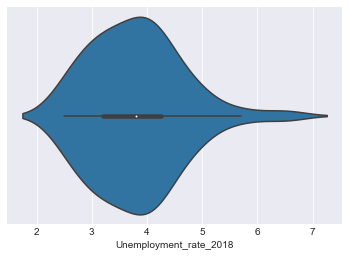

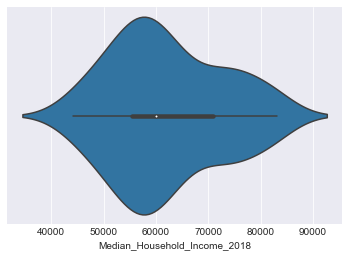

In [18]:
# Violin plot of Civilian_labor_force_2018
sns.violinplot(x='Civilian_labor_force_2018', data=UneploymentDF)
plt.show()

# Violin plot of Employed_2018
sns.violinplot(x='Employed_2018', data=UneploymentDF)
plt.show()

# Violin plot of Unemployed 2018
sns.violinplot(x='Unemployed_2018', data=UneploymentDF)
plt.show()

# Violin plot of Unemployment_rate_2018
sns.violinplot(x='Unemployment_rate_2018', data=UneploymentDF)
plt.show()

# Violin plot of Median_Household_Income_2018
sns.violinplot(x='Median_Household_Income_2018', data=UneploymentDF)
plt.show()

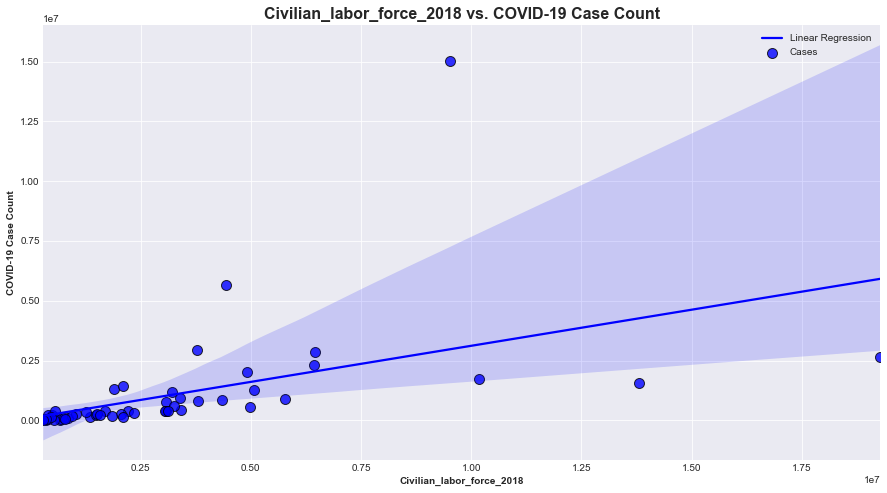

In [19]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Civilian_labor_force_2018', y = 'cases', data = UneploymentDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Civilian_labor_force_2018 vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Civilian_labor_force_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [20]:
model1 = sm.OLS(UneploymentDF['cases'], UneploymentDF['Civilian_labor_force_2018']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.370
Model:                            OLS   Adj. R-squared (uncentered):              0.357
Method:                 Least Squares   F-statistic:                              29.34
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    1.74e-06
Time:                        01:15:16   Log-Likelihood:                         -811.19
No. Observations:                  51   AIC:                                      1624.
Df Residuals:                      50   BIC:                                      1626.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Civilian_labor_force_2018     0.3160      0.058      5.416      0.000       0.199       0.433
==============================================================================
Omnibus:                       85.114   Durbin-Watson:                   2.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1532.397
Skew:                           4.516   Prob(JB):                         0.00
Kurtosis:                      28.290   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

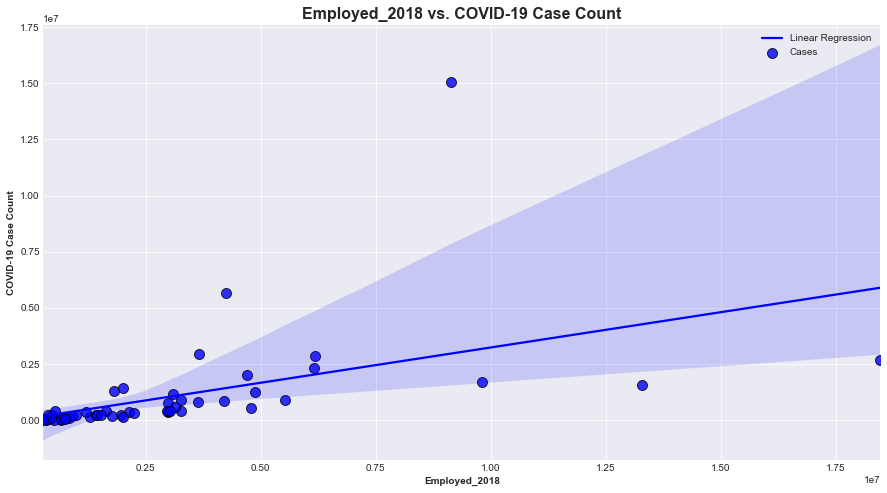

In [21]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Employed_2018', y = 'cases', data = UneploymentDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Employed_2018 vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Employed_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [22]:
model2 = sm.OLS(UneploymentDF['cases'], UneploymentDF['Employed_2018']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.369
Model:                            OLS   Adj. R-squared (uncentered):              0.357
Method:                 Least Squares   F-statistic:                              29.28
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    1.77e-06
Time:                        01:15:16   Log-Likelihood:                         -811.21
No. Observations:                  51   AIC:                                      1624.
Df Residuals:                      50   BIC:                                      1626.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Employed_2018     0.3290      0.061      5.411      0.000       0.207       0.451
==============================================================================
Omnibus:                       85.166   Durbin-Watson:                   2.090
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1534.656
Skew:                           4.520   Prob(JB):                         0.00
Kurtosis:                      28.308   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

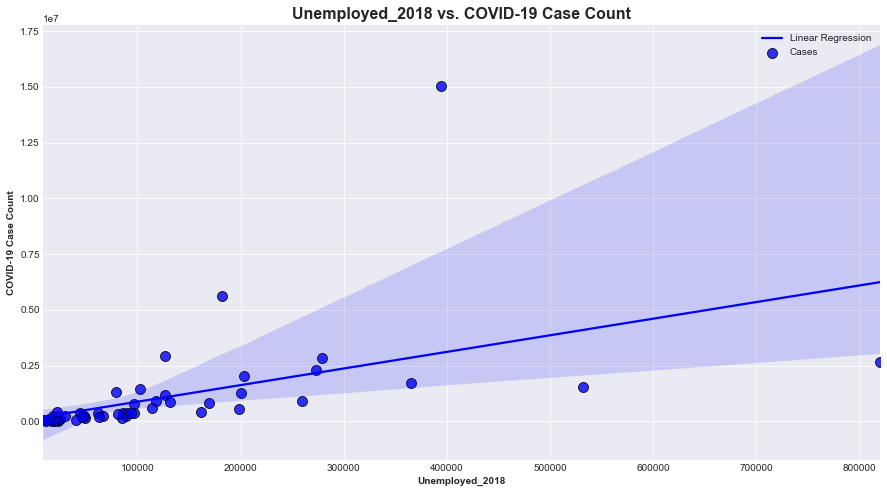

In [23]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Unemployed_2018', y = 'cases', data = UneploymentDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Unemployed_2018 vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Unemployed_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [24]:
model3 = sm.OLS(UneploymentDF['cases'], UneploymentDF['Unemployed_2018']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.376
Model:                            OLS   Adj. R-squared (uncentered):              0.364
Method:                 Least Squares   F-statistic:                              30.18
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    1.32e-06
Time:                        01:15:16   Log-Likelihood:                         -810.92
No. Observations:                  51   AIC:                                      1624.
Df Residuals:                      50   BIC:                                      1626.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Unemployed_2018     7.9174      1.441      5.494      0.000       5.023      10.812
==============================================================================
Omnibus:                       83.650   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1467.633
Skew:                           4.398   Prob(JB):                         0.00
Kurtosis:                      27.765   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

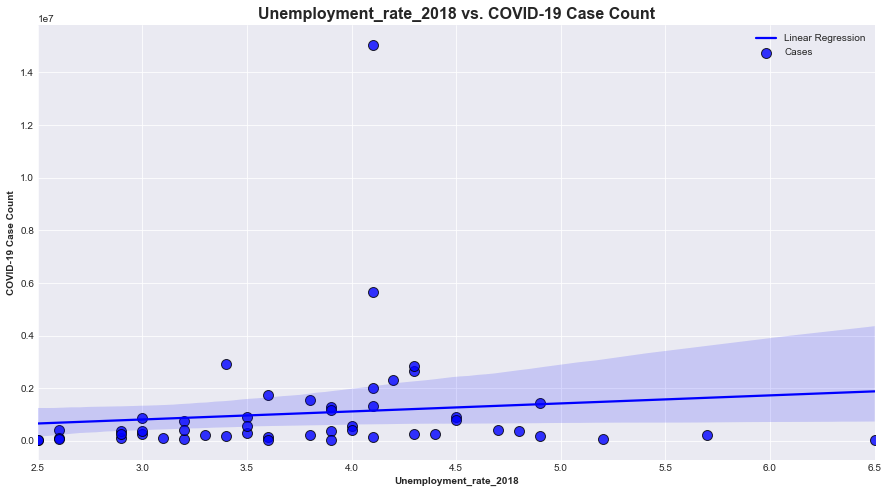

In [25]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Unemployment_rate_2018', y = 'cases', data = UneploymentDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Unemployment_rate_2018 vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Unemployment_rate_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [26]:
model4 = sm.OLS(UneploymentDF['cases'], UneploymentDF['Unemployment_rate_2018']).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.194
Model:                            OLS   Adj. R-squared (uncentered):              0.178
Method:                 Least Squares   F-statistic:                              12.03
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                     0.00109
Time:                        01:15:17   Log-Likelihood:                         -817.47
No. Observations:                  51   AIC:                                      1637.
Df Residuals:                      50   BIC:                                      1639.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Unemployment_rate_2018  2.796e+05   8.06e+04      3.469      0.001    1.18e+05    4.42e+05
==============================================================================
Omnibus:                       91.242   Durbin-Watson:                   2.178
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1868.591
Skew:                           5.011   Prob(JB):                         0.00
Kurtosis:                      30.909   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

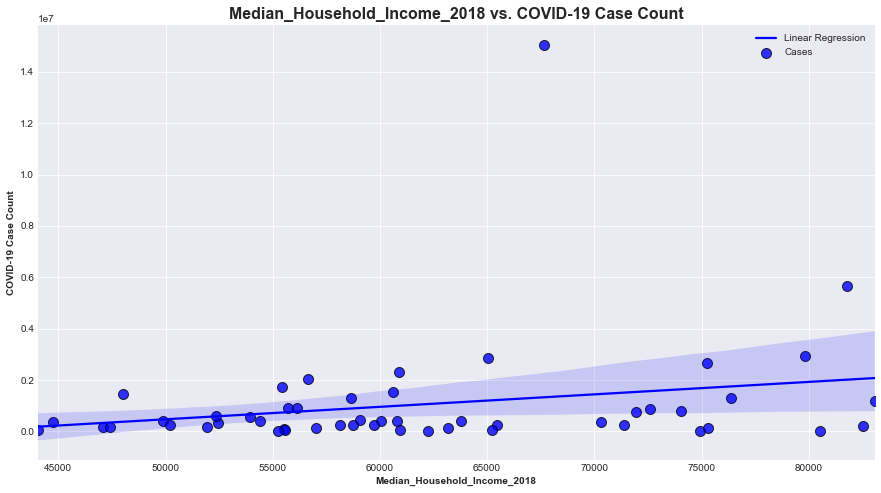

In [27]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'Median_Household_Income_2018', y = 'cases', data = UneploymentDF, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Median_Household_Income_2018 vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('Median_Household_Income_2018', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();



In [28]:
model5 = sm.OLS(UneploymentDF['cases'], UneploymentDF['Median_Household_Income_2018']).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.208
Model:                            OLS   Adj. R-squared (uncentered):              0.193
Method:                 Least Squares   F-statistic:                              13.17
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    0.000669
Time:                        01:15:17   Log-Likelihood:                         -817.00
No. Observations:                  51   AIC:                                      1636.
Df Residuals:                      50   BIC:                                      1638.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Median_Household_Income_2018    17.8903      4.930      3.629      0.001       7.988      27.793
==============================================================================
Omnibus:                       92.650   Durbin-Watson:                   2.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1992.662
Skew:                           5.113   Prob(JB):                         0.00
Kurtosis:                      31.864   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
model6 = sm.OLS(UneploymentDF['cases'], UneploymentDF[['Civilian_labor_force_2018', 'Employed_2018','Unemployed_2018',
                                 'Unemployment_rate_2018', 
                                 'Median_Household_Income_2018']]).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.396
Model:                            OLS   Adj. R-squared (uncentered):              0.344
Method:                 Least Squares   F-statistic:                              7.688
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    7.50e-05
Time:                        01:15:17   Log-Likelihood:                         -810.13
No. Observations:                  51   AIC:                                      1628.
Df Residuals:                      47   BIC:                                      1636.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Civilian_labor_force_2018        7.4379      5.730      1.298      0.201      -4.089      18.965
Employed_2018                   -8.1152      6.493     -1.250      0.218     -21.178       4.948
Unemployed_2018                 15.5530     12.223      1.272      0.209      -9.036      40.142
Unemployment_rate_2018       -2.665e+05   3.02e+05     -0.883      0.382   -8.74e+05    3.41e+05
Median_Household_Income_2018    21.2704     19.458      1.093      0.280     -17.874      60.415
==============================================================================
Omnibus:                       86.044   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1650.640
Skew:                           4.554   Prob(JB):                         0.00
Kurtosis:                      29.340   Cond. No.                     8.23e+15
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.26e-17. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

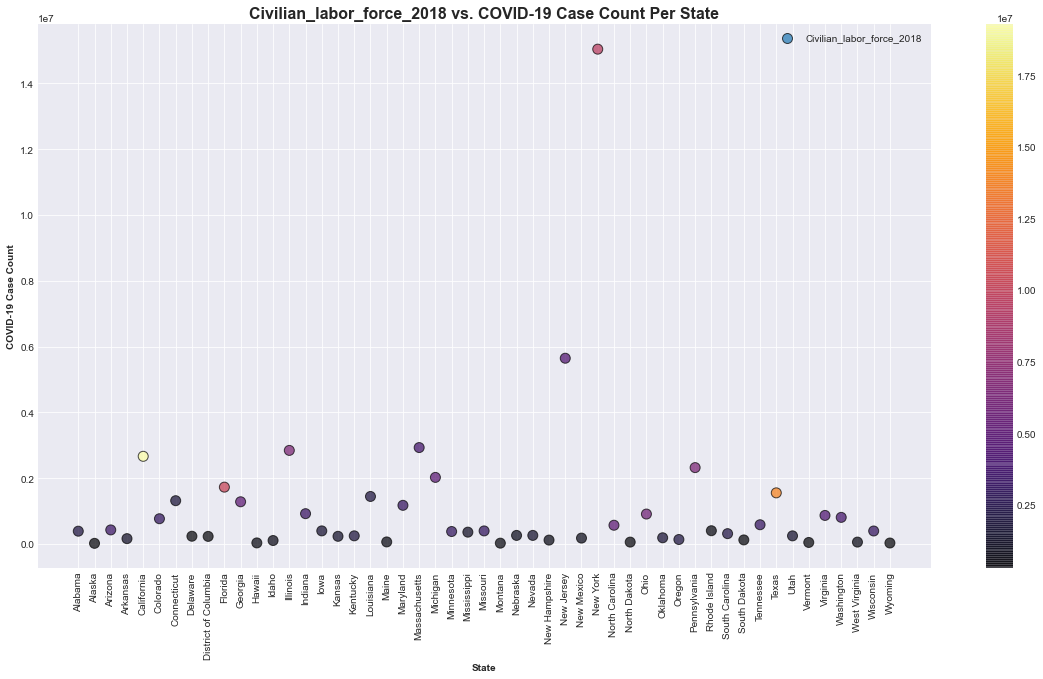

In [30]:
fig = plt.figure(figsize = (20,10))

x = UneploymentDF['State'] 
y = UneploymentDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = UneploymentDF['Civilian_labor_force_2018'], cmap = 'inferno')
plt.title('Civilian_labor_force_2018 vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Civilian_labor_force_2018'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

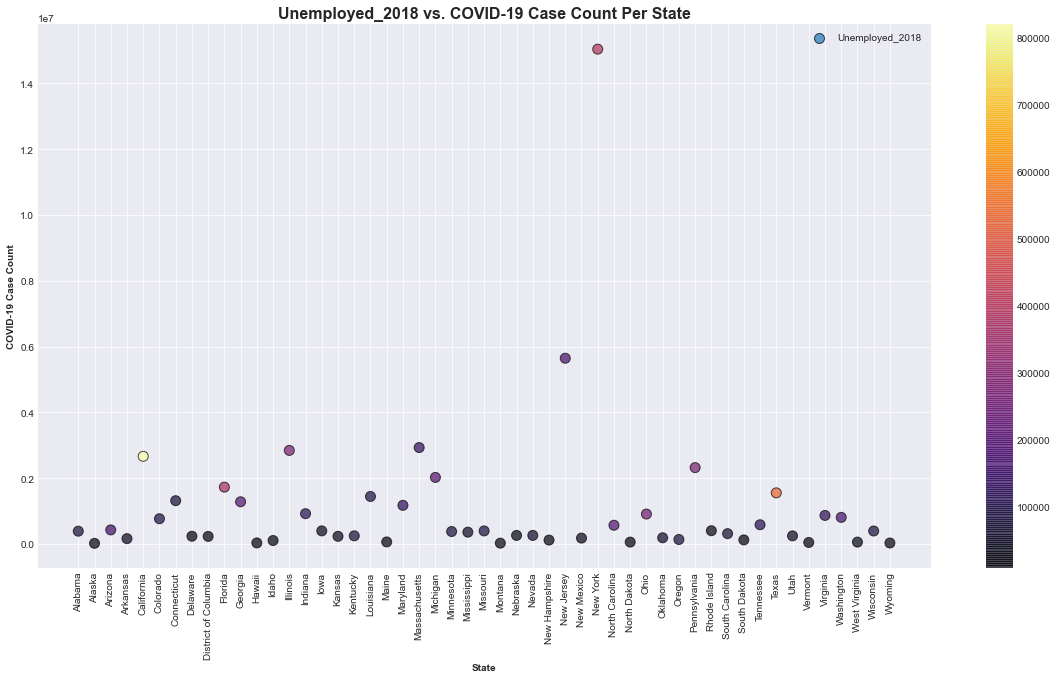

In [31]:
fig = plt.figure(figsize = (20,10))

x = UneploymentDF['State'] 
y = UneploymentDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = UneploymentDF['Unemployed_2018'], cmap = 'inferno')
plt.title('Unemployed_2018 vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Unemployed_2018'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

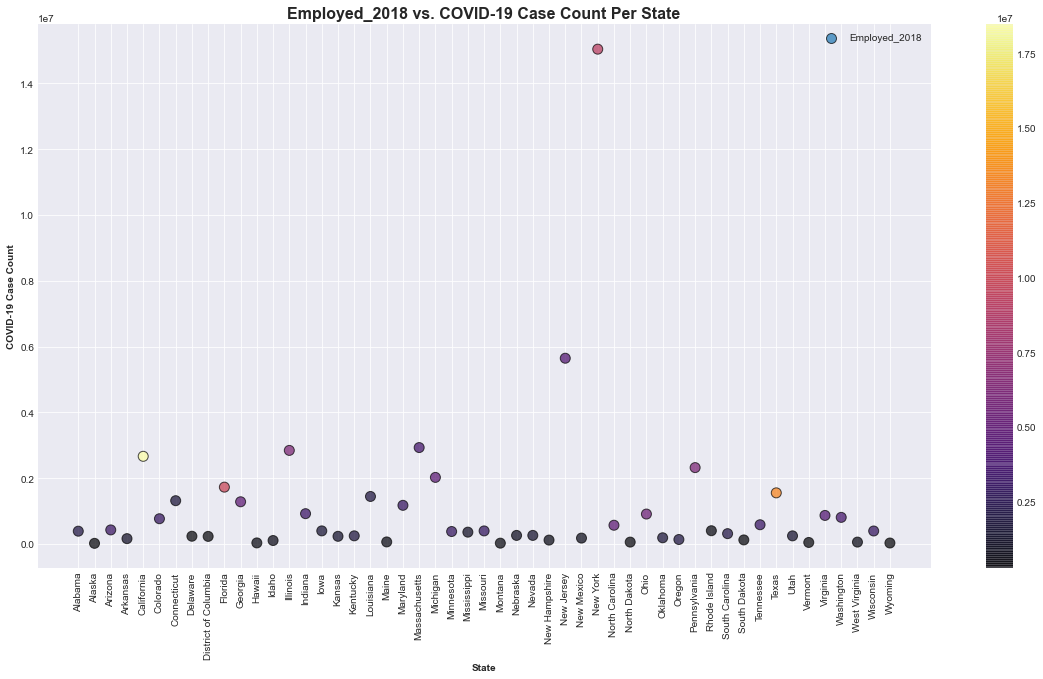

In [32]:
fig = plt.figure(figsize = (20,10))

x = UneploymentDF['State'] 
y = UneploymentDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = UneploymentDF['Employed_2018'], cmap = 'inferno')
plt.title('Employed_2018 vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Employed_2018'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

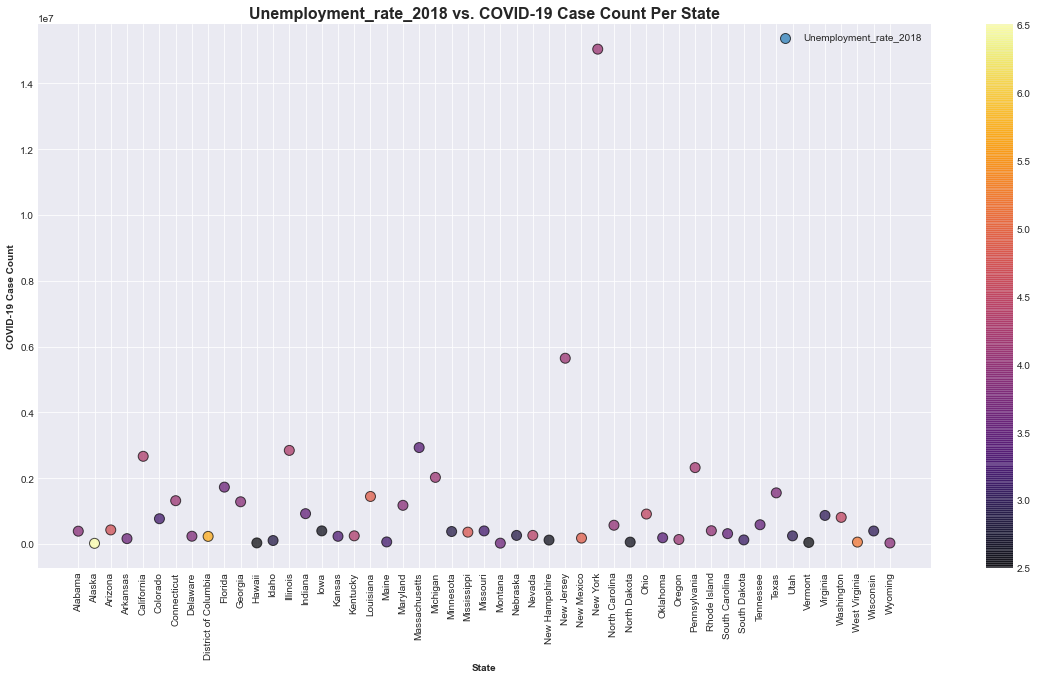

In [33]:
fig = plt.figure(figsize = (20,10))

x = UneploymentDF['State'] 
y = UneploymentDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = UneploymentDF['Unemployment_rate_2018'], cmap = 'inferno')
plt.title('Unemployment_rate_2018 vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Unemployment_rate_2018'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

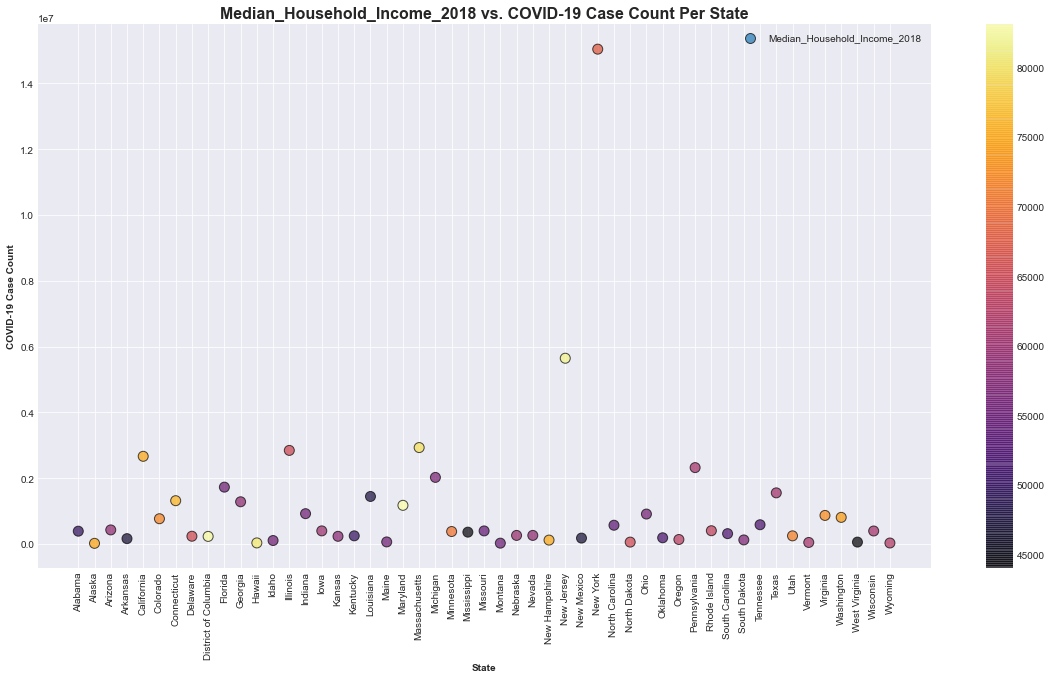

In [34]:
fig = plt.figure(figsize = (20,10))

x = UneploymentDF['State'] 
y = UneploymentDF['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = UneploymentDF['Median_Household_Income_2018'], cmap = 'inferno')
plt.title('Median_Household_Income_2018 vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Median_Household_Income_2018'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

In [3]:
test_len = int(0.25 * len(UneploymentDF))
train_len = len(UneploymentDF) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = UneploymentDF[:train_len]
test = UneploymentDF[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 8)
Test Set Shape: (12, 8)


In [6]:
features_list = ['Civilian_labor_force_2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 3948071803955.0835
MSE Value: 2.1867623186406827e+25
RMS Value: 4676283052426.021
R2 Score: -118933311169358.5


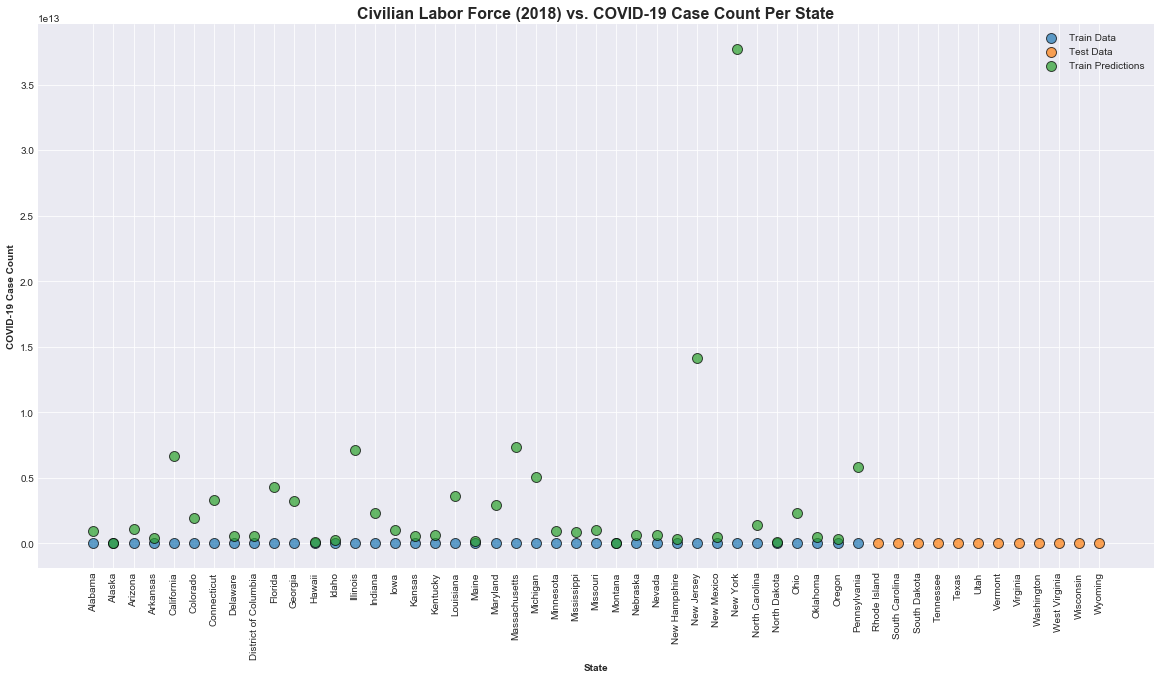

In [7]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Civilian Labor Force (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

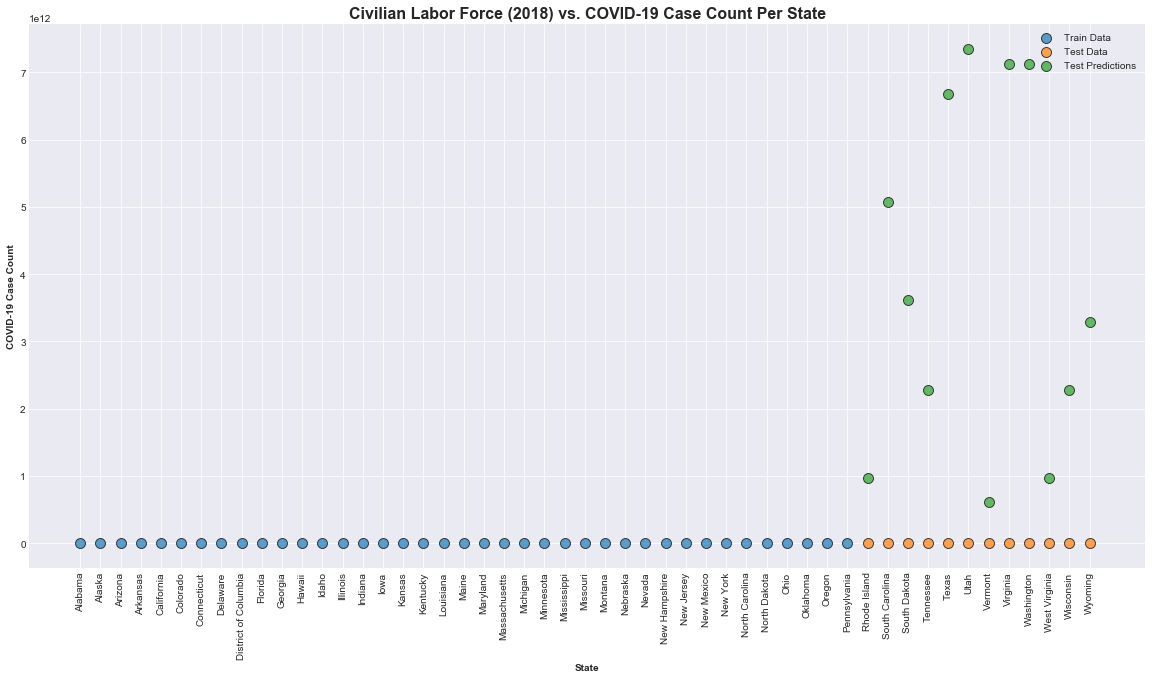

In [8]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Civilian Labor Force (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [9]:
features_list = ['Employed_2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 3674894455176.4165
MSE Value: 2.0786745635978724e+25
RMS Value: 4559248363050.507
R2 Score: -113054650057210.28


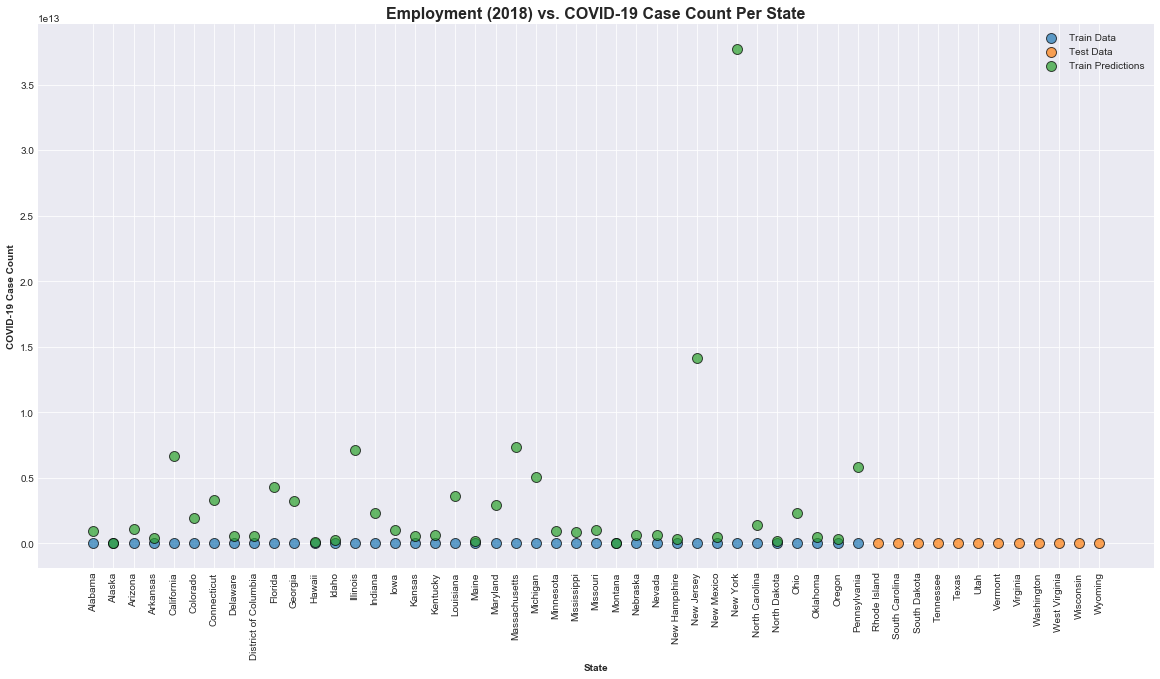

In [10]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Employment (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

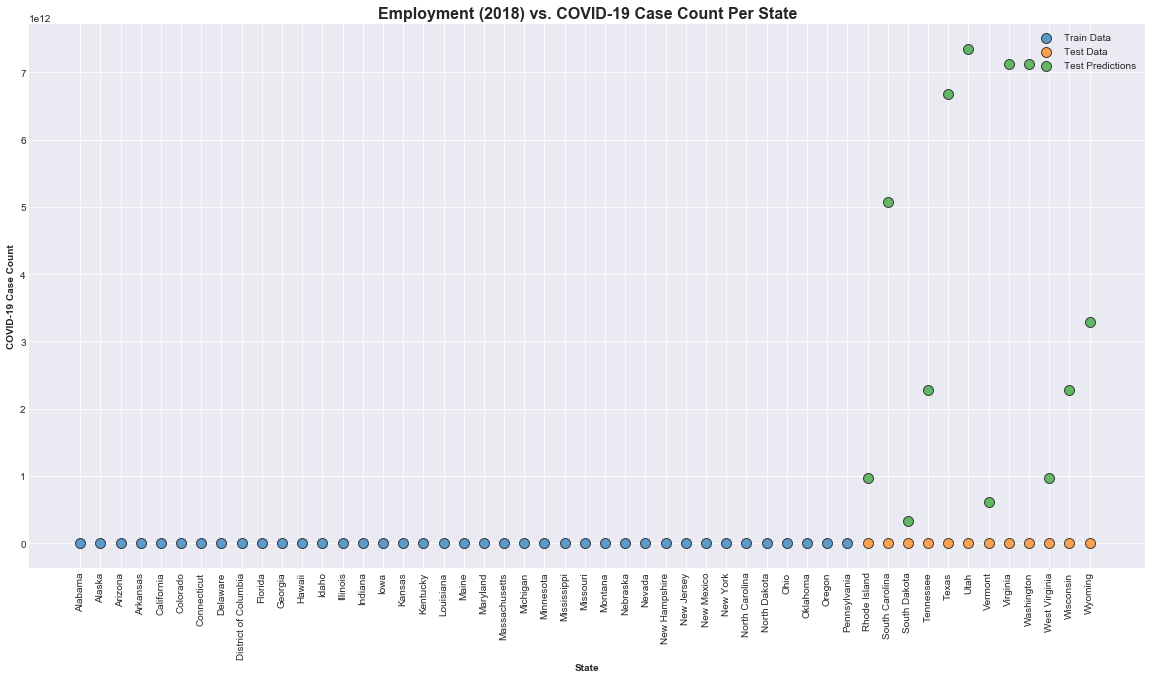

In [11]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Employment (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [12]:
features_list = ['Unemployed_2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 847090370269.75
MSE Value: 7.356639659285685e+23
RMS Value: 857708555354.6545
R2 Score: -4001118485992.2754


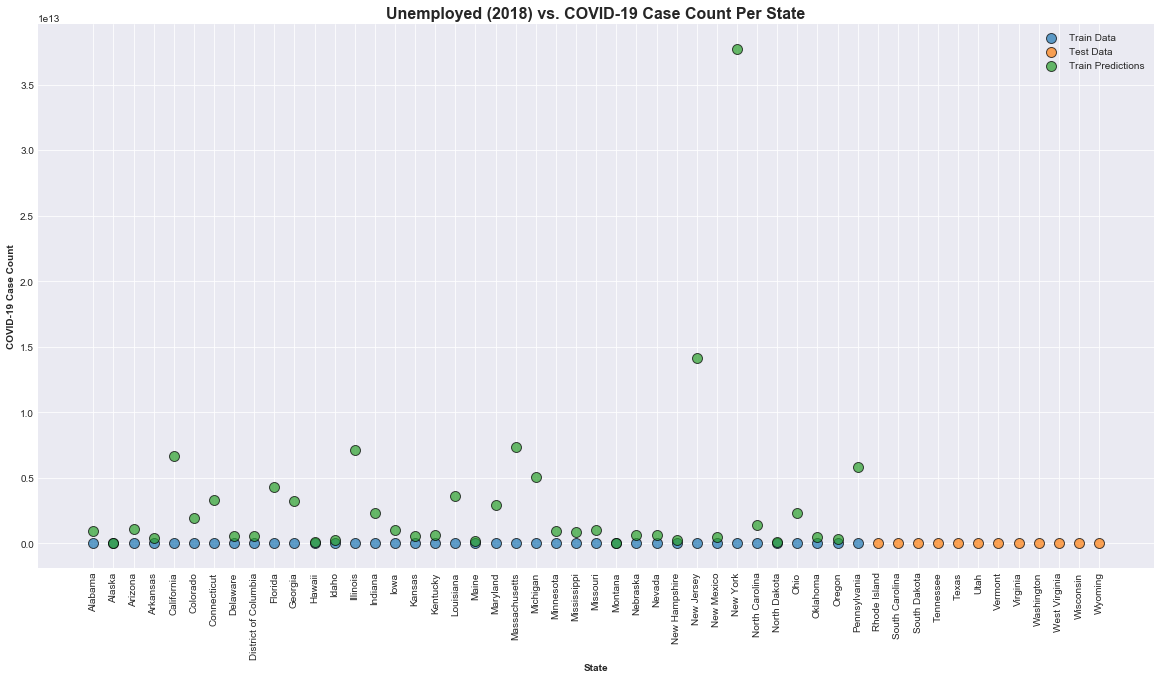

In [13]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Unemployed (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

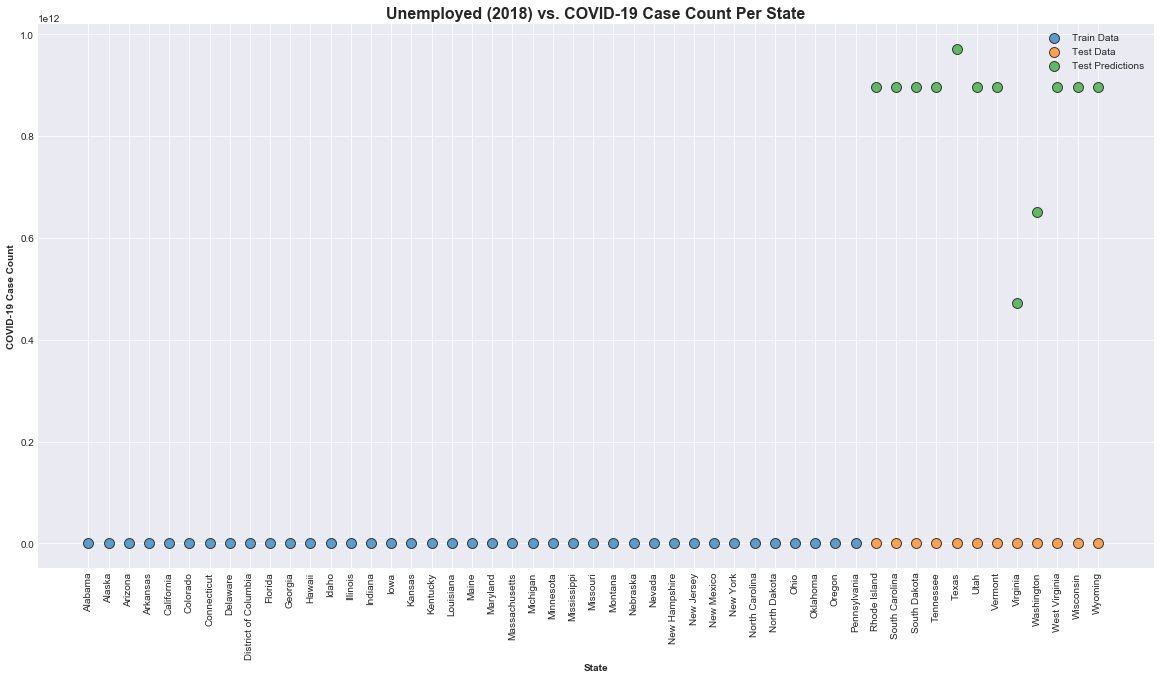

In [14]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Unemployed (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [15]:
features_list = ['Unemployment_rate_2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 3906612042803.0835
MSE Value: 1.5261617652974266e+25
RMS Value: 3906612042803.107
R2 Score: -83004664283645.3


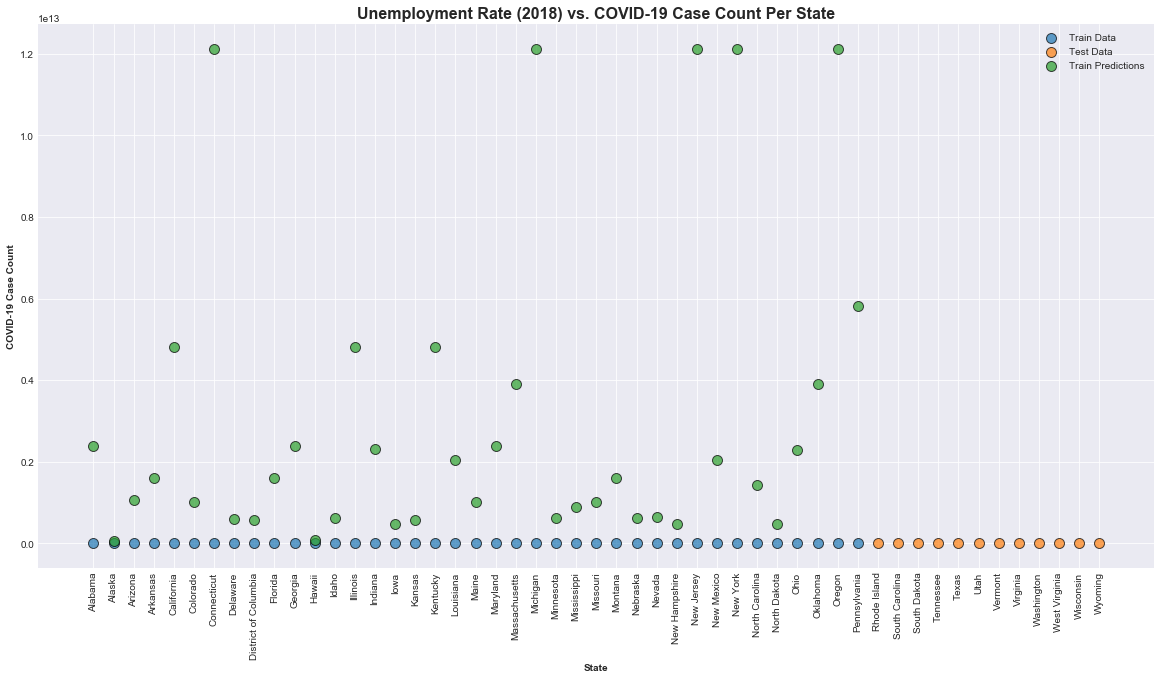

In [16]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Unemployment Rate (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

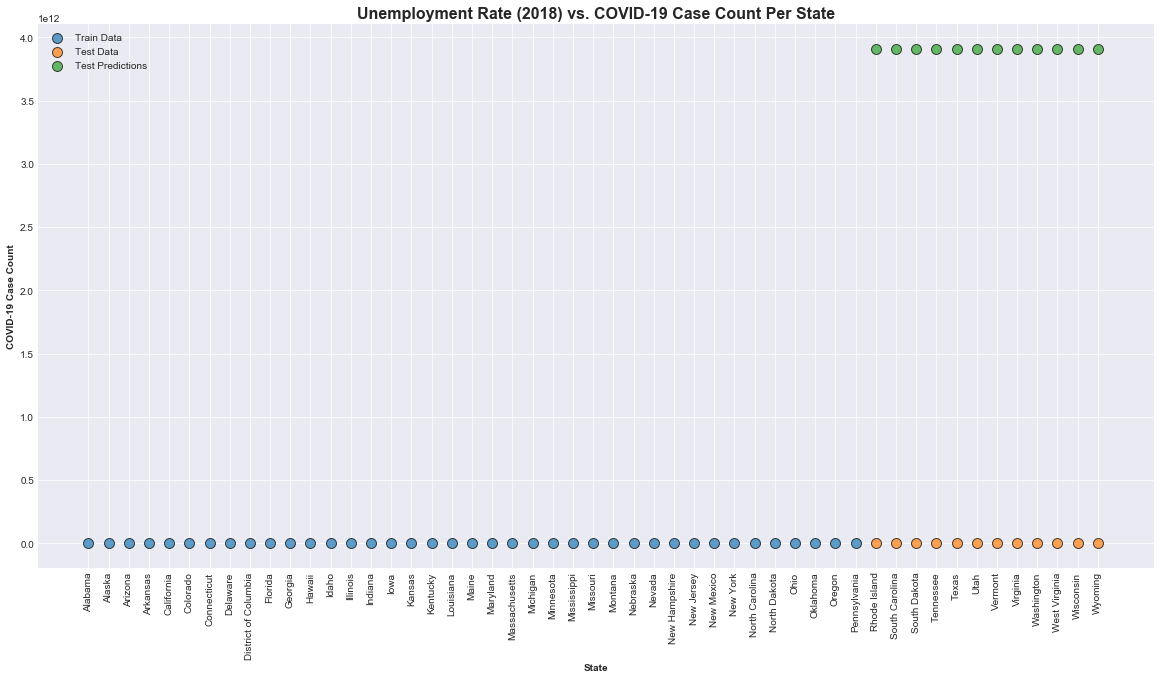

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Unemployment Rate (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [18]:
features_list = ['Median_Household_Income_2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 5067516746803.083
MSE Value: 2.5679725979129887e+25
RMS Value: 5067516746803.102
R2 Score: -139666520434567.81


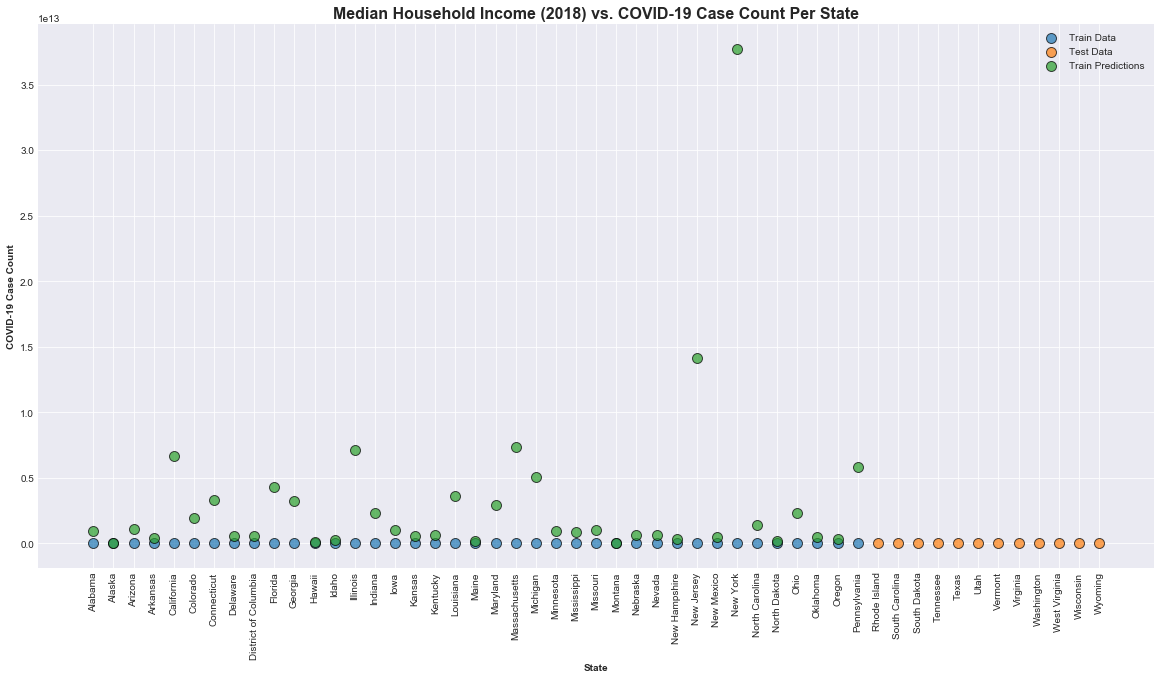

In [19]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Median Household Income (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

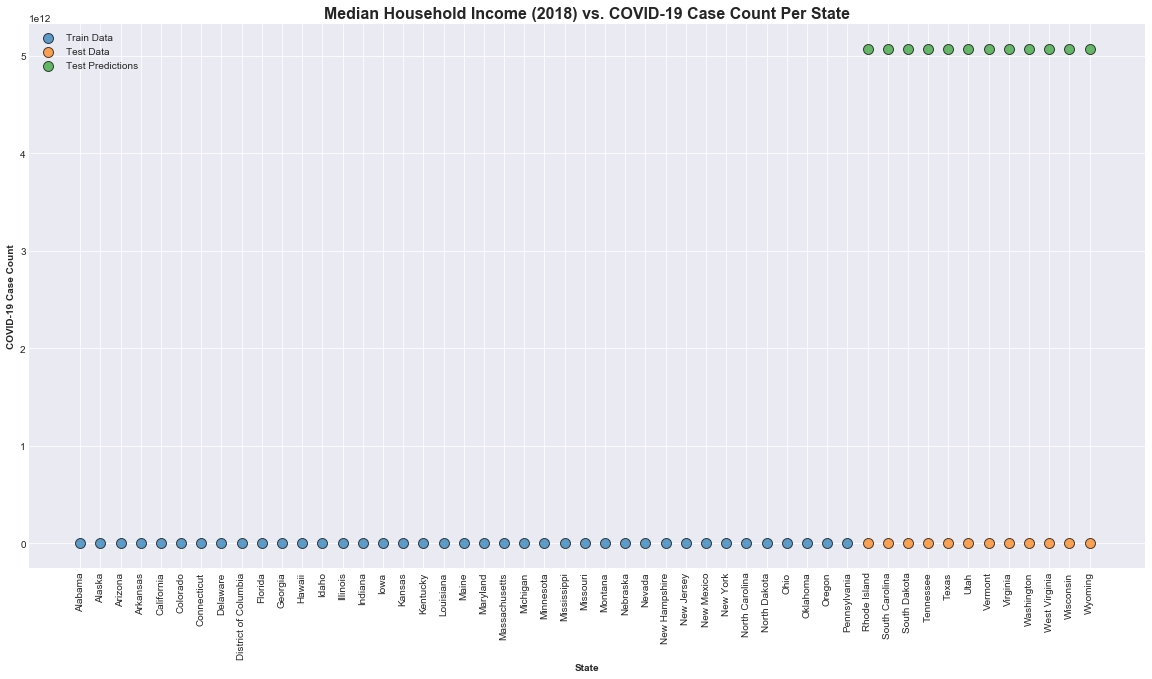

In [20]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Median Household Income (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [21]:
features_list = ['Civilian_labor_force_2018','Employed_2018','Unemployed_2018','Median_Household_Income_2018']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

XGBmodel = XGBRegressor()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions_scaled = XGBmodel.predict(X_train_scaled)
train_predictions = scaler.inverse_transform(train_predictions_scaled)
test_predictions_scaled = XGBmodel.predict(X_test_scaled)
test_predictions = scaler.inverse_transform(test_predictions_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 1491535218397.75
MSE Value: 2.7167464183047446e+24
RMS Value: 1648255568261.4104
R2 Score: -14775800935572.605


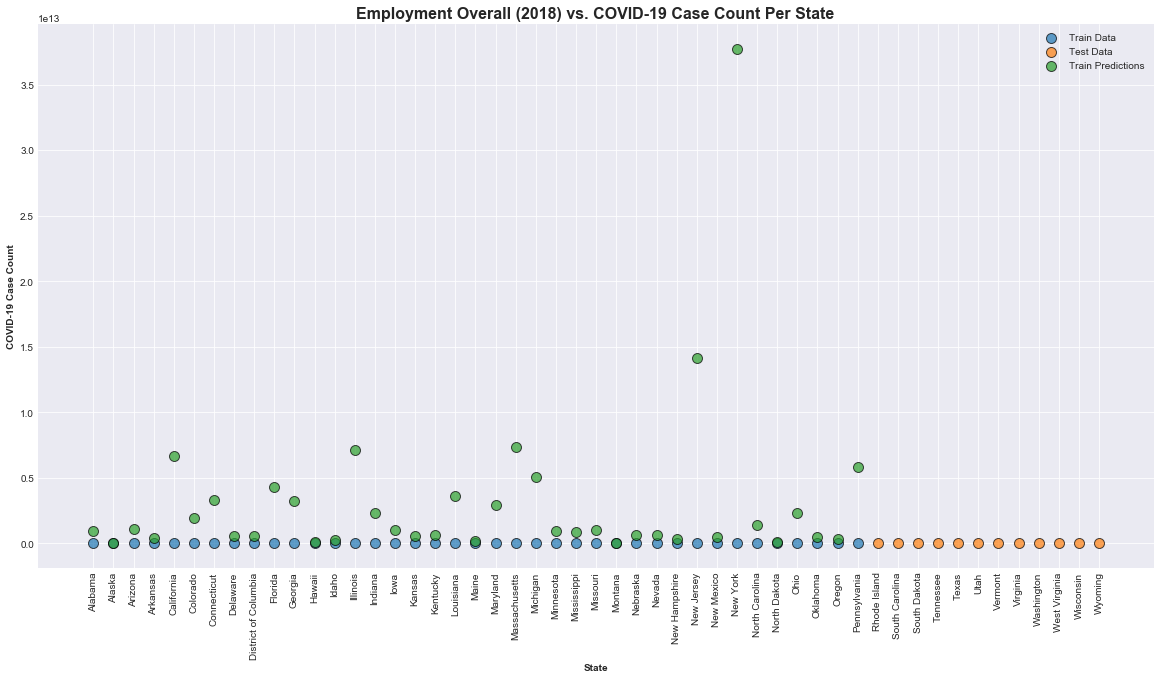

In [22]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Employment Overall (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

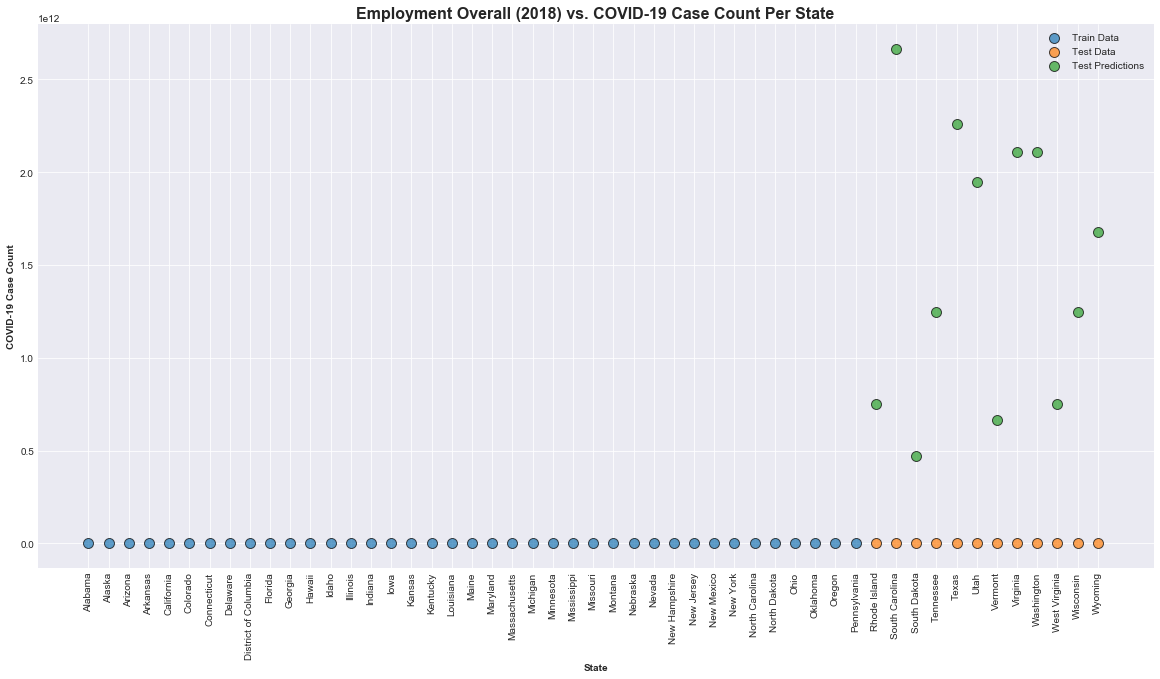

In [23]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('Employment Overall (2018) vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();